In [3]:
import glob
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

fs=glob.glob('/Users/mgrecu/GPM/2ADPR_tiles/*.nc')
fs=sorted(fs)
print(len(fs))

89


In [58]:
sfcPrecipL=[]
pTypeL=[]
zKuL=[]
bzdL=[]
bsfcL=[]
bcfL=[]
stormTopL=[]
piaFinalL=[]
for f in fs[:]:
    with nc.Dataset(f) as fh:
        #print(fh.variables.keys())
        stormTop=fh.variables['stormTop'][:]
        sfcPrecip=fh.variables['sfcPrecip'][:]
        sfcPrecipW=fh.variables['sfcPrecipW'][:]
        pType=fh.variables['pType'][:]
        bzd=fh.variables['bzd'][:]
        bsfc=fh.variables['bsfc'][:]
        bcf=fh.variables['bcf'][:]
        piaFinal=fh.variables['piaFinal'][:,:,:,0]
        a=np.nonzero(pType[:,:,:].max(axis=(1,2))>0)
        b=np.nonzero(bzd[a[0],:,:].max(axis=(1,2))<160)
        zKu=fh.variables['zKu'][:]
        nt=b[0].shape[0]
        zKuL.extend(zKu[a[0][b],:,:,:].reshape(nt,100,176))
        stormTopL.extend(stormTop[a[0][b],:,:].reshape(nt,100))
        bzdL.extend(bzd[a[0][b],:,:].reshape(nt,100))
        bcfL.extend(bcf[a[0][b],:,:].reshape(nt,100))
        piaFinalL.extend(piaFinal[a[0][b],:,:].reshape(nt,100))
        bsfcL.extend(bsfc[a[0][b],:,:].reshape(nt,100))
        sfcPrecipL.extend(sfcPrecipW[a[0][b],:,:].reshape(nt,100))
        pTypeL.extend(pType[a[0][b],:,:].reshape(nt,100))
    #break

In [5]:

alpha_st=[0.0000861,0.0001084,0.0004142,0.000282,0.000285]
alpha_cv=[0.0000861,0.0001109,0.0004109,0.0004109,0.0004172]
beta_st=0.792
beta_cv=0.7713
dr=0.125
a_st,b_st=0.02282,0.6727
a_cv,b_cv=0.0424,0.6434
def hb(zKum,alpha,beta,dr,srt_piaKu):
    q=0.2*np.log(10)
    zeta=q*beta*alpha*10**(0.1*zKum*beta)*dr
    zetamax=1.-10**(-srt_piaKu/10.*beta)
    #zetamax=1.-10**(-4.0/10.*beta)
    if zeta.cumsum()[-1]>zetamax:
        eps=0.9999*zetamax/zeta.cumsum()[-1]
        zeta=eps*zeta
    else:
        eps=1.0
    corrc=eps*zeta.cumsum()
    zc=zKum-10/beta*np.log10(1-corrc)
    return zc,eps

In [101]:
sfcPrecipL=np.array(sfcPrecipL)
a=np.nonzero(sfcPrecipL>8)
print(sfcPrecipL[a[0]].sum()/sfcPrecipL.sum())
refSfcPrecipL=[]
p1_L=[]
p2_L=[]
import tqdm
sfcPrecip_hbL=[]
patchDataL=[]
iskipped=0
for i,zKu1p in tqdm.tqdm(enumerate(zKuL)):
    bzd1p=bzdL[i]
    bcf1p=bcfL[i]
    stormTop1p=stormTopL[i]
    itop=176-(stormTop1p.data/125).astype(int)-5
    #print(bsfc1,bzd1,)
    dn_st=-0.2
    dn_cv=-0.5
    p1p=[]
    p2p=[]
    zFL=[]
    stormTop1p[stormTop1p<0]=0
    zetaFL=[]
    iskip=0
    a=np.nonzero(pTypeL[i]>0)
    for j in a[0]:
        if itop[j]>=bzd1p[j]-2 or bcf1p[j]<=bzd1p[j]+2:
            iskip=1
            continue
    if iskip==1:
        iskipped+=1
        continue
    for j in range(100):
        bzd1=bzd1p[j]
        bcf1=bcf1p[j]
        zKu1=zKu1p[j]
        zFL.append(zKu1[bzd1])
        zetaFL.append((10**(0.1*zKu1[bzd1-40:bzd1]*0.7)).sum())
        if pTypeL[i][j]==1 and bcf1>bzd1+2 and itop[j]<bzd1-2:
            alpha=alpha_st
            beta=beta_st
            a=a_st
            b=b_st
            node=[itop[j],bzd1-2,bzd1,bzd1+2,bcf1]
            alpha=np.interp(range(itop[j],bcf1),node,alpha_st)
            alpha*=10**(dn_st*(1-beta_st))
            zku_true,eps=hb(zKu1[itop[j]:bcf1],alpha,beta_st,dr,4)
            sfcRainRate_hb=a_st*10**(dn_st*(1-b_st))*10**(0.1*zku_true[-1]*b_st)
            p1p.append(sfcRainRate_hb)
            p2p.append(sfcPrecipL[i][j])
        else:
            if pTypeL[i][j]==2 and bcf1>bzd1+2 and itop[j]<bzd1-2:
                alpha=alpha_cv
                beta=beta_cv
                node=[itop[j],bzd1-1,bzd1,bzd1+2,bcf1]
                alpha=np.interp(range(itop[j],bcf1),node,alpha_cv)
                alpha*=10**(dn_cv*(1-beta_cv))
                zku_true,eps=hb(zKu1[itop[j]:bcf1],alpha,beta_cv,dr,10)
                sfcRainRate_hb=a_cv*10**(dn_cv*(1-b_cv))*10**(0.1*zku_true[-1]*b_cv)
            #break
                p1p.append(sfcRainRate_hb)
                p2p.append(sfcPrecipL[i][j])
            else:
                p1p.append(0)
                p2p.append(0)
    if len(p1p)>0:
        p1_L.append(np.mean(p1p))
        p2_L.append(np.mean(p2p))
    sfcPrecip_hbL.append(p1p)
    refSfcPrecipL.append(p2p)
    if len(p1p)!=100:
        print('error')   
        break
    else:
        patchDataL.append(np.array([zFL,zetaFL,p1p,pTypeL[i],piaFinalL[i],sfcPrecipL[i]]).T)
    #break
    

7.298171


45241it [00:47, 3198.36it/s]

In [100]:
#patchDataL.append(np.array([zFL,zetaFL,p1p,pTypeL[i],piaFinalL[i],sfcPrecipL[i]]).T)
patchDataL=np.array(patchDataL)
import xarray as xr
print(patchDataL.shape)

(131134, 100, 6)


In [91]:
zFL_=xr.DataArray(patchDataL[:,:,0],dims=['nrec','npix'])
zetaFL_=xr.DataArray(patchDataL[:,:,1],dims=['nrec','npix'])
sfcPrecip_hb_=xr.DataArray(patchDataL[:,:,2],dims=['nrec','npix'])
pType_=xr.DataArray(patchDataL[:,:,3],dims=['nrec','npix'])
piaFinal_=xr.DataArray(patchDataL[:,:,4],dims=['nrec','npix'])
sfcPrecip_=xr.DataArray(patchDataL[:,:,5],dims=['nrec','npix'])
patchData_=xr.DataArray(patchDataL,dims=['nrec','npix','nvar'])

ds=xr.Dataset({'zFL':zFL_,
            'zetaFL':zetaFL_,
            'sfcPrecip_hb':sfcPrecip_hb_,
            'pType':pType_,
            'piaFinal':piaFinal_,
            'sfcPrecip':sfcPrecip_,'patchData':patchData_})

# save to compressed netcdf
ds.to_netcdf('patchData.nc',encoding={'zFL':{'zlib':True,'complevel':5},
                                        'zetaFL':{'zlib':True,'complevel':5},
                                        'sfcPrecip_hb':{'zlib':True,'complevel':5},
                                        'pType':{'zlib':True,'complevel':5},
                                        'piaFinal':{'zlib':True,'complevel':5},
                                        'sfcPrecip':{'zlib':True,'complevel':5},'patchData':{'zlib':True,'complevel':5}})

In [98]:
print(zetaFL)
print(bzd1p)
(10**(0.1*zKu1p[5][bzd1p[5]-40:bzd1p[5]]*0.7)).sum()
print(np.log10(1+zetaFL_).mean(axis=0))

[370.44876, 345.92804, 521.79333, 818.6426, 810.28906, 1016.3442, 780.88696, 619.3618, 581.527, 355.7807, 202.31209, 186.63954, 271.76816, 513.344, 685.8308, 799.0878, 829.14453, 574.693, 498.84015, 376.0531, 146.42111, 96.45679, 113.72423, 259.23242, 434.71655, 519.80347, 623.124, 548.0924, 411.66388, 283.88297, 137.3276, 41.453842, 65.53164, 179.3757, 263.8433, 261.495, 328.38828, 423.55145, 306.65292, 248.57976, 131.28856, 153.11938, 127.43187, 100.70399, 172.89612, 451.11807, 118.828896, 276.36688, 260.38962, 259.34796, 172.7038, 100.33165, 73.64934, 46.88037, 103.42178, 173.69498, 48.250305, 98.616486, 175.35146, 151.86238, 50.227047, 111.65753, 116.234886, 123.88412, 92.63172, 166.08876, 81.68974, 108.01133, 92.35303, 125.609726, 49.936264, 96.462204, 90.88316, 106.38927, 65.33385, 136.39091, 169.49567, 118.25575, 104.612076, 143.99219, 108.353935, 83.39308, 127.83736, 163.11662, 127.68393, 179.64938, 109.83777, 132.58467, 74.88403, 129.57698, 58.49878, 97.37462, 177.64479, 128.7

[[1.         0.73053995]
 [0.73053995 1.        ]]
98449


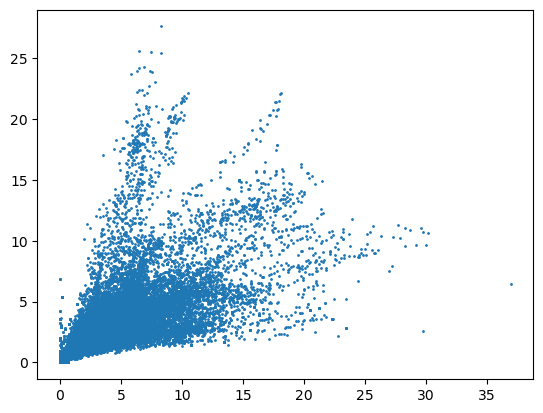

In [31]:
p1_L=np.array(p1_L)
p2_L=np.array(p2_L)
a=np.nonzero(p1_L==p1_L)
print(np.corrcoef(p1_L[a],p2_L[a]))
print(len(p1_L[a]))
plt.scatter(p1_L[a],p2_L[a],s=1)

[0, 0.13024831805994536, 0.31237638181171473, 0.8553381568147373, 1.8084485177887943, 1.4207270866847705, 0.8144441545860116, 0.3127691366865618, 0, 0, 0, 0, 0, 0.23704950700632535, 0.6595493187534195, 1.496360832153104, 0.7676597704904634, 0.3123408295296514, 0.0635036669531938, 0, 0, 0, 0, 0, 0, 0.2592300467723586, 0.3383452311269437, 0.2685239284330649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.18180565623653783, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0.41886905, 0.3500645, 0.84572434, 1.7889115, 1.2999208, 0.828594, 0.33787248, 0, 0, 0, 0, 0, 0.2485891, 0.6632216, 1.3443934, 0.7889747, 0.33226445, 0.0, 0, 0, 0, 0, 0, 0, 0.3134468, 0.36596563, 0.31082582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.19331779, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

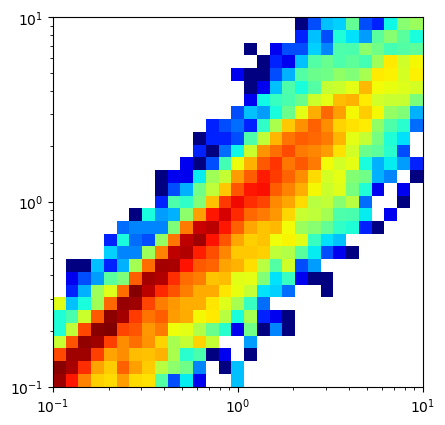

In [38]:
print(p1p)
print(p2p)
from matplotlib import colors as mpl
ax=plt.subplot(111)
h2d=plt.hist2d(p1_L,p2_L,bins=10**(np.linspace(-1,1.0,30)),cmap='jet',norm=mpl.LogNorm())
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')

In [42]:
p1_L=np.array(p1_L)
p2_L=np.array(p2_L)
a=np.nonzero(abs(p2_L-9)<1)
print(np.corrcoef(p1_L[a],p2_L[a]))
print(np.mean(p1_L[a]),np.mean(p2_L[a]))
print(np.std(p1_L[a]-p2_L[a]))

[[1.         0.07139965]
 [0.07139965 1.        ]]
8.46055278282945 8.973098843421305
3.8314628190374194


1.0
66497


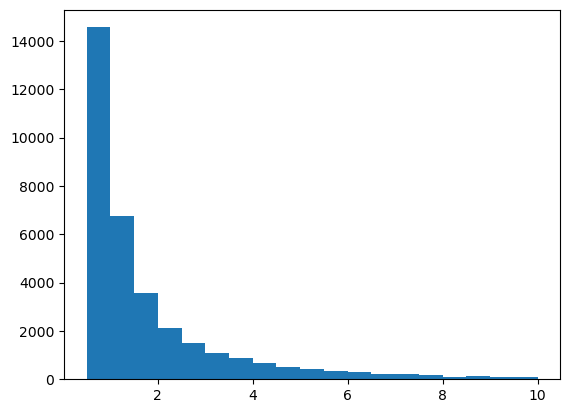

In [3]:
h1=plt.hist(sfcPrecipL,bins=np.arange(1,21)*0.5)
pTypeL=np.array(pTypeL)
a=np.where(pTypeL>0)
print(len(a[0])/len(pTypeL))
print(len(a[0]))